<a href="https://colab.research.google.com/github/abhipise2704/Human_Activity_Recognition/blob/master/HAR_LSTM_colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 21
## LSTM ON HUMAN ACTIVITY RECOGNITION
## abhipise2704@gmail.com_21

# 1: DATA UPLOADING /DATA PREPROCESSING 

### 1.1 Loading Folder HAR on  google drive 

In [1]:
#https://colab.research.google.com/notebooks/io.ipynb#scrollTo=XDg9OBaYqRMd
#https://medium.com/@master_yi/importing-datasets-in-google-colab-c816fc654f97
# Code to read csv file into Colaboratory:
#!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

link = 'https://drive.google.com/open?id=118toouH8ifByKJHmmowyjOjGyir-YAvi'

fluff, id = link.split('=')
print (id) # Verify that you have everything after '='


downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('HumanActivityRecognition.zip')  
#data = pd.read_csv('preprocessed_data')
# Dataset is now stored in a Pandas Dataframe
#data.shape

118toouH8ifByKJHmmowyjOjGyir-YAvi


In [0]:
import zipfile


zip_ref = zipfile.ZipFile("/content/HumanActivityRecognition.zip", 'r')
zip_ref.extractall("")
zip_ref.close()

### 1.2 Importing Library 

In [0]:
import pandas as pd
import numpy as np

In [0]:
# Activities are the class labels
# It is a 6 class classification
ACTIVITIES = {
    0: 'WALKING',
    1: 'WALKING_UPSTAIRS',
    2: 'WALKING_DOWNSTAIRS',
    3: 'SITTING',
    4: 'STANDING',
    5: 'LAYING',
}

# Utility function to print the confusion matrix
def confusion_matrix(Y_true, Y_pred):
    Y_true = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_true, axis=1)])
    Y_pred = pd.Series([ACTIVITIES[y] for y in np.argmax(Y_pred, axis=1)])

    return pd.crosstab(Y_true, Y_pred, rownames=['True'], colnames=['Pred'])

### 1.4 Data Reading to Xtrain Xtest y_train and y_test

In [0]:
# Data directory
DATADIR = 'UCI_HAR_Dataset'

In [0]:
# Raw data signals
# Signals are from Accelerometer and Gyroscope
# The signals are in x,y,z directions
# Sensor signals are filtered to have only body acceleration
# excluding the acceleration due to gravity
# Triaxial acceleration from the accelerometer is total acceleration
SIGNALS = [
    "body_acc_x",
    "body_acc_y",
    "body_acc_z",
    "body_gyro_x",
    "body_gyro_y",
    "body_gyro_z",
    "total_acc_x",
    "total_acc_y",
    "total_acc_z"
]

In [0]:
# Utility function to read the data from csv file
def _read_csv(filename):
    return pd.read_csv(filename, delim_whitespace=True, header=None)

# Utility function to load the load
def load_signals(subset):
    signals_data = []

    for signal in SIGNALS:
        filename = f'HAR/UCI_HAR_Dataset/{subset}/Inertial Signals/{signal}_{subset}.txt'
        df=_read_csv(filename)
        df=df.values
        signals_data.append(np.asmatrix(df))

    # Transpose is used to change the dimensionality of the output,
    # aggregating the signals by combination of sample/timestep.
    # Resultant shape is (7352 train/2947 test samples, 128 timesteps, 9 signals)
    return np.transpose(signals_data, (1, 2, 0))

In [0]:

def load_y(subset):
    """
    The objective that we are trying to predict is a integer, from 1 to 6,
    that represents a human activity. We return a binary representation of 
    every sample objective as a 6 bits vector using One Hot Encoding
    (https://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html)
    """
    filename = f'HAR/UCI_HAR_Dataset/{subset}/y_{subset}.txt'
    y = _read_csv(filename)[0]
    y=pd.get_dummies(y)
    y=y.values
    #y=np.asmatrix(y)
    

    return y

In [0]:
def load_data():
    """
    Obtain the dataset from multiple files.
    Returns: X_train, X_test, y_train, y_test
    """
    X_train, X_test = load_signals('train'), load_signals('test')
    y_train, y_test = load_y('train'), load_y('test')

    return X_train, X_test, y_train, y_test

In [0]:
# Importing tensorflow
np.random.seed(42)
import tensorflow as tf
tf.random.set_seed(42)

In [0]:
# Configuring a session
session_conf = tf.compat.v1.ConfigProto(
    intra_op_parallelism_threads=1,
    inter_op_parallelism_threads=1
)

In [12]:
# Import Keras
from keras import backend as K
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.get_session(sess)

Using TensorFlow backend.


In [0]:
# Importing libraries
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout

In [0]:
# Initializing parameters
epochs = 30
batch_size = 27
n_hidden = 32

In [0]:
# Utility function to count the number of classes
def _count_classes(y):
    return len(set([tuple(category) for category in y]))

In [0]:
# Loading the train and test data
X_train, X_test, Y_train, Y_test = load_data()

In [17]:
timesteps = len(X_train[0])
input_dim = len(X_train[0][0])
n_classes = _count_classes(Y_train)

print(timesteps)
print(input_dim)
print(len(X_train))

128
9
7352


# 2 Defining the Architecture of LSTM(model 1)

### 2.1 Initialize Model

In [50]:
# Initiliazing the sequential model
model = Sequential()
# Configuring the parameters
model.add(LSTM(n_hidden, input_shape=(timesteps, input_dim)))
# Adding a dropout layer
model.add(Dropout(0.5))
# Adding a dense output layer with sigmoid activation
model.add(Dense(n_classes, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (None, 32)                5376      
_________________________________________________________________
dropout_5 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 198       
Total params: 5,574
Trainable params: 5,574
Non-trainable params: 0
_________________________________________________________________


### 2.2 Model Compilation & Evaluation 

In [0]:
# Compiling the model
model.compile(loss='categorical_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

In [59]:
# Training the model
model.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=epochs)

Train on 7352 samples, validate on 2947 samples
Epoch 1/30
7352/7352 [==============================] - 96s 13ms/step - loss: 1.3178 - accuracy: 0.4506 - val_loss: 1.1267 - val_accuracy: 0.5151
Epoch 2/30
7352/7352 [==============================] - 92s 13ms/step - loss: 0.9312 - accuracy: 0.6034 - val_loss: 0.8452 - val_accuracy: 0.6121
Epoch 3/30
7352/7352 [==============================] - 93s 13ms/step - loss: 0.7748 - accuracy: 0.6434 - val_loss: 0.7749 - val_accuracy: 0.6125
Epoch 4/30
7352/7352 [==============================] - 94s 13ms/step - loss: 0.7149 - accuracy: 0.6604 - val_loss: 0.7583 - val_accuracy: 0.5993
Epoch 5/30
7352/7352 [==============================] - 98s 13ms/step - loss: 0.6708 - accuracy: 0.6800 - val_loss: 1.0034 - val_accuracy: 0.6295
Epoch 6/30
7352/7352 [==============================] - 99s 13ms/step - loss: 0.6183 - accuracy: 0.7199 - val_loss: 0.6839 - val_accuracy: 0.7448
Epoch 7/30
7352/7352 [==============================] - 97s 13ms/step - loss

### 2.4 Confusion Matrix on Test Data for Model 1 

In [0]:
# Confusion Matrix
print(confusion_matrix(Y_test, model.predict(X_test)))

Pred                LAYING  SITTING  STANDING  WALKING  WALKING_DOWNSTAIRS  \
True                                                                         
LAYING                 512        0        25        0                   0   
SITTING                  3      410        75        0                   0   
STANDING                 0       87       445        0                   0   
WALKING                  0        0         0      481                   2   
WALKING_DOWNSTAIRS       0        0         0        0                 382   
WALKING_UPSTAIRS         0        0         0        2                  18   

Pred                WALKING_UPSTAIRS  
True                                  
LAYING                             0  
SITTING                            3  
STANDING                           0  
WALKING                           13  
WALKING_DOWNSTAIRS                38  
WALKING_UPSTAIRS                 451  


In [0]:
score = model.evaluate(X_test, Y_test)

2947/2947 [==============================] - 4s 2ms/step


In [0]:
score

[0.3087582236972612, 0.9097387173396675]

- With a simple 2 layer architecture we got 90.09% accuracy and a loss of 0.30
- We can further imporve the performace with Hyperparameter tuning

# 3 LSTM model 2 

### 3.1 GridSearchCV for droprOut and LSTM units 


##### Model Function  

In [0]:
#https://github.com/krishnaik06/Hidden-Layers-Neurons/blob/master/How%20to%20Select%20how%20many%20hidden%20layer%20and%20neurons%20in%20a%20neural%20network.ipynb
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/
from keras.layers import BatchNormalization


def create_model(lstm_units_1,lstm_units_2,dropout_1,dropout_2):
    # create model
    model = Sequential()
    
    model.add(LSTM(lstm_units_1,return_sequences=True,
                   input_shape=(timesteps, input_dim)))
    model.add(BatchNormalization())
    model.add(Dropout(dropout_1))
    
    model.add(LSTM(lstm_units_2))
    model.add(Dropout(dropout_2))
    
    model.add(Dense(n_classes, activation='softmax'))
    # Compile model
    model.compile(loss='binary_crossentropy', optimizer='rmsprop', metrics=['accuracy'])
    return model


### 3.2 GridSearchCV to Hyperparametr tuning 

In [0]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

model = KerasClassifier(build_fn=create_model, verbose=10)

In [0]:
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

lstm_units_1_list=[100,150]
lstm_units_2_list=[50,100]
dropout_1_list=[0.6,0.7,0.8]
dropout_2_list=[0.7,0.8,0.9]
#kernel_ini_list=['random_uniform','glorot_normal']
param_grid_dict = dict(lstm_units_1=lstm_units_1_list, 
                  lstm_units_2=lstm_units_2_list,
                  dropout_1 = dropout_1_list,
                  dropout_2=dropout_2_list)

grid = GridSearchCV( estimator=model,param_grid=param_grid_dict,verbose=10,cv=3)

In [36]:
#https://machinelearningmastery.com/grid-search-hyperparameters-deep-learning-models-python-keras/

grid_result = grid.fit(X_train,Y_train,epochs=2, batch_size=500)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))



Fitting 3 folds for each of 36 candidates, totalling 108 fits
[CV] dropout_1=0.6, dropout_2=0.7, lstm_units_1=100, lstm_units_2=50 .


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.7, lstm_units_1=100, lstm_units_2=50, score=0.186, total=  20.7s
[CV] dropout_1=0.6, dropout_2=0.7, lstm_units_1=100, lstm_units_2=50 .


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   20.7s remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.7, lstm_units_1=100, lstm_units_2=50, score=0.307, total=  18.8s
[CV] dropout_1=0.6, dropout_2=0.7, lstm_units_1=100, lstm_units_2=50 .


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   39.5s remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.7, lstm_units_1=100, lstm_units_2=50, score=0.315, total=  18.6s
[CV] dropout_1=0.6, dropout_2=0.7, lstm_units_1=100, lstm_units_2=100 


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.1s remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.7, lstm_units_1=100, lstm_units_2=100, score=0.237, total=  18.8s
[CV] dropout_1=0.6, dropout_2=0.7, lstm_units_1=100, lstm_units_2=100 


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  1.3min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.7, lstm_units_1=100, lstm_units_2=100, score=0.354, total=  18.1s
[CV] dropout_1=0.6, dropout_2=0.7, lstm_units_1=100, lstm_units_2=100 


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.6min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.7, lstm_units_1=100, lstm_units_2=100, score=0.280, total=  18.7s
[CV] dropout_1=0.6, dropout_2=0.7, lstm_units_1=150, lstm_units_2=50 .


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  1.9min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.7, lstm_units_1=150, lstm_units_2=50, score=0.216, total=  18.3s
[CV] dropout_1=0.6, dropout_2=0.7, lstm_units_1=150, lstm_units_2=50 .


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed:  2.2min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.7, lstm_units_1=150, lstm_units_2=50, score=0.309, total=  18.2s
[CV] dropout_1=0.6, dropout_2=0.7, lstm_units_1=150, lstm_units_2=50 .


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:  2.5min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.7, lstm_units_1=150, lstm_units_2=50, score=0.274, total=  18.9s
[CV] dropout_1=0.6, dropout_2=0.7, lstm_units_1=150, lstm_units_2=100 


[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:  2.8min remaining:    0.0s


Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.7, lstm_units_1=150, lstm_units_2=100, score=0.291, total=  19.0s
[CV] dropout_1=0.6, dropout_2=0.7, lstm_units_1=150, lstm_units_2=100 
Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.7, lstm_units_1=150, lstm_units_2=100, score=0.241, total=  18.5s
[CV] dropout_1=0.6, dropout_2=0.7, lstm_units_1=150, lstm_units_2=100 
Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.7, lstm_units_1=150, lstm_units_2=100, score=0.330, total=  19.3s
[CV] dropout_1=0.6, dropout_2=0.8, lstm_units_1=100, lstm_units_2=50 .
Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.8, lstm_units_1=100, lstm_units_2=50, score=0.251, total=  19.5s
[CV] dropout_1=0.6, dropout_2=0.8, lstm_units_1=100, lstm_units_2=50 .
Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0.8, lstm_units_1=100, lstm_units_2=50, score=0.261, total=  19.6s
[CV] dropout_1=0.6, dropout_2=0.8, lstm_units_1=100, lstm_units_2=50 .
Epoch 1/2
Epoch 2/2
[CV]  dropout_1=0.6, dropout_2=0

[Parallel(n_jobs=1)]: Done 108 out of 108 | elapsed: 35.9min finished


Epoch 1/2
Epoch 2/2
Best: 0.389147 using {'dropout_1': 0.8, 'dropout_2': 0.9, 'lstm_units_1': 100, 'lstm_units_2': 50}
0.269457 (0.058771) with: {'dropout_1': 0.6, 'dropout_2': 0.7, 'lstm_units_1': 100, 'lstm_units_2': 50}
0.290260 (0.048187) with: {'dropout_1': 0.6, 'dropout_2': 0.7, 'lstm_units_1': 100, 'lstm_units_2': 100}
0.266595 (0.038364) with: {'dropout_1': 0.6, 'dropout_2': 0.7, 'lstm_units_1': 150, 'lstm_units_2': 50}
0.287139 (0.036463) with: {'dropout_1': 0.6, 'dropout_2': 0.7, 'lstm_units_1': 150, 'lstm_units_2': 100}
0.240339 (0.021995) with: {'dropout_1': 0.6, 'dropout_2': 0.8, 'lstm_units_1': 100, 'lstm_units_2': 50}
0.331482 (0.038697) with: {'dropout_1': 0.6, 'dropout_2': 0.8, 'lstm_units_1': 100, 'lstm_units_2': 100}
0.269036 (0.060769) with: {'dropout_1': 0.6, 'dropout_2': 0.8, 'lstm_units_1': 150, 'lstm_units_2': 50}
0.290548 (0.084069) with: {'dropout_1': 0.6, 'dropout_2': 0.8, 'lstm_units_1': 150, 'lstm_units_2': 100}
0.276113 (0.053793) with: {'dropout_1': 0.6, 

### 3.4 Best Hyperparameter for 2 Layered LSTM

In [37]:
print("="*80)
print("Best_Hyperparamaeter_LSTM::")
print("-"*80)
print(grid_result.best_params_)
print("="*80)

Best_Hyperparamaeter_LSTM::
--------------------------------------------------------------------------------
{'dropout_1': 0.8, 'dropout_2': 0.9, 'lstm_units_1': 100, 'lstm_units_2': 50}


## 3.5 Best LSTM model with Best Hyperparameter 

In [0]:
tf.keras.backend.clear_session()

In [19]:
# Importing libraries
#https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers.core import Dense, Dropout
from keras.regularizers import L1L2
from keras.layers import BatchNormalization


model_best = Sequential()
reg = L1L2(0.01, 0.01)    

model_best.add(LSTM(100,return_sequences=True,
                    kernel_initializer='glorot_normal',
                    input_shape=(timesteps, input_dim),
                    bias_regularizer=reg))

model_best.add(BatchNormalization())
model_best.add(Dropout(0.8))
    
model_best.add(LSTM(50))
model_best.add(Dropout(0.9))
    
model_best.add(Dense(n_classes,  activation='sigmoid'))
    
model_best.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 128, 100)          44000     
_________________________________________________________________
batch_normalization_2 (Batch (None, 128, 100)          400       
_________________________________________________________________
dropout_3 (Dropout)          (None, 128, 100)          0         
_________________________________________________________________
lstm_4 (LSTM)                (None, 50)                30200     
_________________________________________________________________
dropout_4 (Dropout)          (None, 50)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 6)                 306       
Total params: 74,906
Trainable params: 74,706
Non-trainable params: 200
________________________________________________

### 3.6 Compilation & Model_best Evaluation On Test Data

In [0]:
# Compiling the model
from keras.callbacks import ModelCheckpoint
model_best.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])
checkpoint_3 = ModelCheckpoint("model_best.h5",monitor="val_acc",mode="max",save_best_only = True,verbose=1)

In [21]:

##https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/
from keras.callbacks import EarlyStopping
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1)


# Training the model
model_best.fit(X_train,
          Y_train,
          batch_size=batch_size,
          validation_data=(X_test, Y_test),
          epochs=65,
          callbacks=[checkpoint_3]
          )

Train on 7352 samples, validate on 2947 samples
Epoch 1/65
7352/7352 [==============================] - 103s 14ms/step - loss: 2.1565 - accuracy: 0.7202 - val_loss: 1.6109 - val_accuracy: 0.8636
Epoch 2/65


/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:707: RuntimeWarning: Can save best model only with val_acc available, skipping.
  'skipping.' % (self.monitor), RuntimeWarning)


7352/7352 [==============================] - 102s 14ms/step - loss: 1.3361 - accuracy: 0.8350 - val_loss: 0.9806 - val_accuracy: 0.8641
Epoch 3/65
7352/7352 [==============================] - 102s 14ms/step - loss: 0.7641 - accuracy: 0.8574 - val_loss: 0.4662 - val_accuracy: 0.8888
Epoch 4/65
7352/7352 [==============================] - 102s 14ms/step - loss: 0.3815 - accuracy: 0.8690 - val_loss: 0.2816 - val_accuracy: 0.8687
Epoch 5/65
7352/7352 [==============================] - 103s 14ms/step - loss: 0.2971 - accuracy: 0.8756 - val_loss: 0.2533 - val_accuracy: 0.8869
Epoch 6/65
7352/7352 [==============================] - 102s 14ms/step - loss: 0.2781 - accuracy: 0.8812 - val_loss: 0.2047 - val_accuracy: 0.8984
Epoch 7/65
7352/7352 [==============================] - 102s 14ms/step - loss: 0.2698 - accuracy: 0.8829 - val_loss: 0.2230 - val_accuracy: 0.8953
Epoch 8/65
7352/7352 [==============================] - 103s 14ms/step - loss: 0.2637 - accuracy: 0.8846 - val_loss: 0.2319 - val

 ### 3.7 Accuracy (Training & Validation) vs No of Epoch

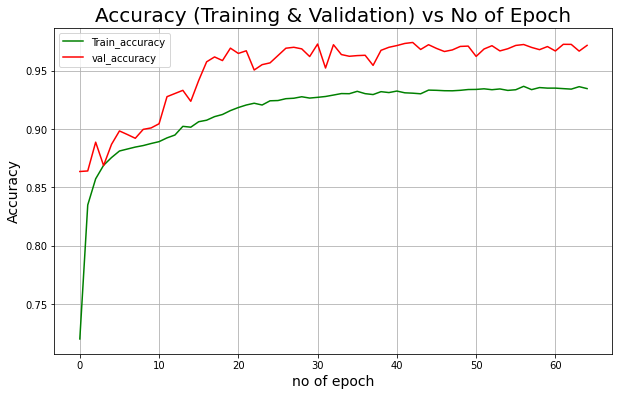

In [22]:
import pandas as pd
import numpy as np
losses = pd.DataFrame(model_best.history.history)

losses.head(2)

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
plt.figure(figsize=(10,6))

plt.plot(losses['accuracy'],color='green',label='Train_accuracy')
plt.plot(losses['val_accuracy'],color='red',label='val_accuracy')
plt.xlabel('no of epoch',fontsize=14)
plt.ylabel('Accuracy',fontsize=14)
plt.title('Accuracy (Training & Validation) vs No of Epoch',fontsize=20)
plt.legend()
plt.grid()

### 3.8 Confusion Matrix on test data of LSTM 

Pred                LAYING  SITTING  ...  WALKING_DOWNSTAIRS  WALKING_UPSTAIRS
True                                 ...                                      
LAYING                 537        0  ...                   0                 0
SITTING                  0      426  ...                   0                 3
STANDING                 0      119  ...                   0                 0
WALKING                  0        9  ...                   5                 0
WALKING_DOWNSTAIRS       0        1  ...                 419                 0
WALKING_UPSTAIRS         0       10  ...                  22               434

[6 rows x 6 columns]


Text(131.09375, 0.5, 'True Label')

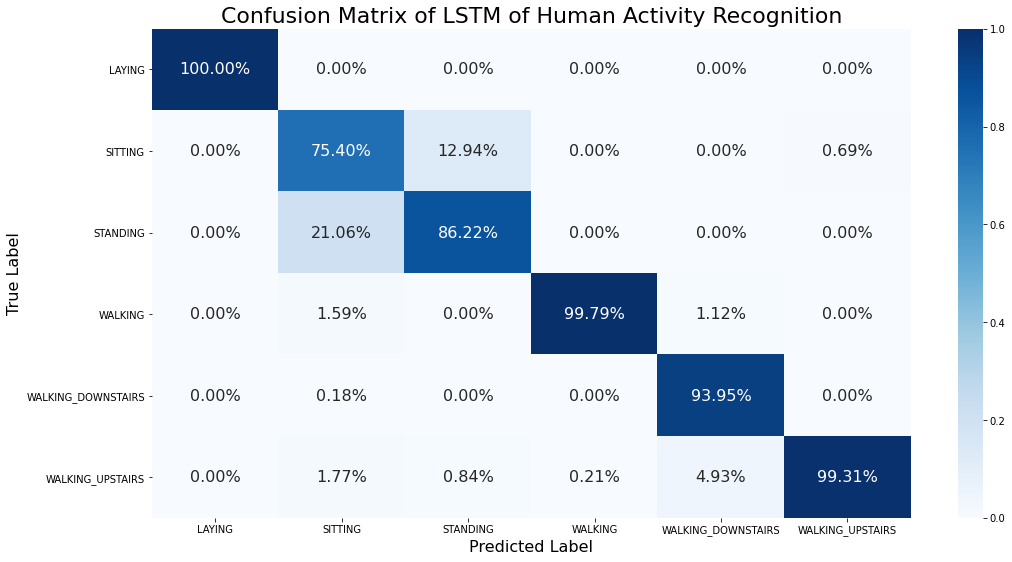

In [48]:
# Confusion Matrix
cm_best=confusion_matrix(Y_test, model_best.predict(X_test))

print(confusion_matrix(Y_test, model_best.predict(X_test)))

import seaborn as sns
plt.figure(figsize=(17,9))
sns.heatmap(cm_best/np.sum(cm_best),annot=True,fmt='.2%',cmap='Blues',annot_kws={"size": 16})
plt.title('Confusion Matrix of LSTM of Human Activity Recognition',fontsize=22)
plt.xlabel('Predicted Label',fontsize=16)
plt.ylabel('True Label',fontsize=16)

In [46]:
score = model_best.evaluate(X_test, Y_test)

2947/2947 [==============================] - 3s 1ms/step


In [47]:
score

[0.09540406648056347, 0.9716662764549255]

**OBESERVATION:**

1.   With 2 layered LSTM with different dropout rates we get 97.16% accuracy

2.   LSTM units for 1st Layer=100||
LSTM units for 2nd Layer=50 ||
DropOut_1=0.8 ||
DropOut_1=0.9 ||






#4 Conclusion 

In [53]:
#!/usr/bin/python3

from prettytable import PrettyTable
    
x = PrettyTable()

x.field_names = ["MODEL", "FEATURIZATION","Accuracy"]

x.add_row(["Best_LR", "Feature_engineered_FFT","95.11%"])
x.add_row(["LSTM_1_layered", "Raw_time_series_data","90.03%"])
x.add_row(["LSTM_2_layered", "Raw_time_series_data","97.16%"])


print(x)

+----------------+------------------------+----------+
|     MODEL      |     FEATURIZATION      | Accuracy |
+----------------+------------------------+----------+
|    Best_LR     | Feature_engineered_FFT |  95.11%  |
| LSTM_1_layered |  Raw_time_series_data  |  90.03%  |
| LSTM_2_layered |  Raw_time_series_data  |  97.16%  |
+----------------+------------------------+----------+
